In [1]:
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt


class RotaryEmbedding(nn.Module):
    def __init__(self, dim, original_impl=False, device=None, dtype=None):
        super().__init__()
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2, device=device).to(dtype=dtype) / dim))
        self.register_buffer("inv_freq", inv_freq)
        self.dim = dim
        self.original_impl = original_impl

    def forward_impl(self, seq_len: int, n_elem: int, dtype: torch.dtype, device: torch.device, base: int = 10000):
        theta = 1.0 / (base ** (torch.arange(0, n_elem, 2, dtype=dtype, device=device) / n_elem))
        seq_idx = torch.arange(seq_len, dtype=dtype, device=device)
        idx_theta = torch.outer(seq_idx, theta).float()
        cache = torch.stack([torch.cos(idx_theta), torch.sin(idx_theta)], dim=-1)
        # cache = torch.stack([idx_theta, -idx_theta], dim=-1)
        if dtype in (torch.float16, torch.bfloat16, torch.int8):
            cache = cache.bfloat16() if dtype == torch.bfloat16 else cache.half()
        return cache

    def forward(self, max_seq_len, offset=0):
        return self.forward_impl(max_seq_len, self.dim, dtype=self.inv_freq.dtype, device=self.inv_freq.device)

def apply_rotary_pos_emb(x: torch.Tensor, rope_cache: torch.Tensor) -> torch.Tensor:
    sq, b, np, hn = x.size(0), x.size(1), x.size(2), x.size(3)
    rot_dim = rope_cache.shape[-2] * 2
    x, x_pass = x[..., :rot_dim], x[..., rot_dim:]
    rope_cache = rope_cache[:sq]
    xshaped = x.reshape(sq, -1, np, rot_dim // 2, 2)
    rope_cache = rope_cache.view(sq, -1, 1, xshaped.size(3), 2)
    x_out2 = torch.stack([
            xshaped[..., 0] * rope_cache[..., 0] - xshaped[..., 1] * rope_cache[..., 1],
            xshaped[..., 1] * rope_cache[..., 0] + xshaped[..., 0] * rope_cache[..., 1],
        ],
        -1,
    )
    x_out2 = x_out2.flatten(3)
    return torch.cat((x_out2, x_pass), dim=-1)



In [2]:
seq_len = 128
b = 1
np = 32
hn = 64
x = torch.ones(seq_len, b, np, hn)
rope_model = RotaryEmbedding(dim=64)
rope_cache = rope_model(seq_len)
X = apply_rotary_pos_emb(x, rope_cache)


## 位置信息

### 位置热力图


> 在⼆进制表⽰中，较⾼⽐特位的交替频率低于较低⽐特位，与下⾯的热图所⽰相似，只是位置编码通过使⽤三⻆函数在编码维度上降低频率。
> 
> 由于输出是浮点数，因此此类连续表⽰⽐⼆进制表⽰法更节省空间。

每个位置的 `嵌入` 可以视为一个 32 维度的向量
- 较⾼⽐特位的交替频率低于较低⽐特位
- 为了节省空间，使用浮点数连续表示

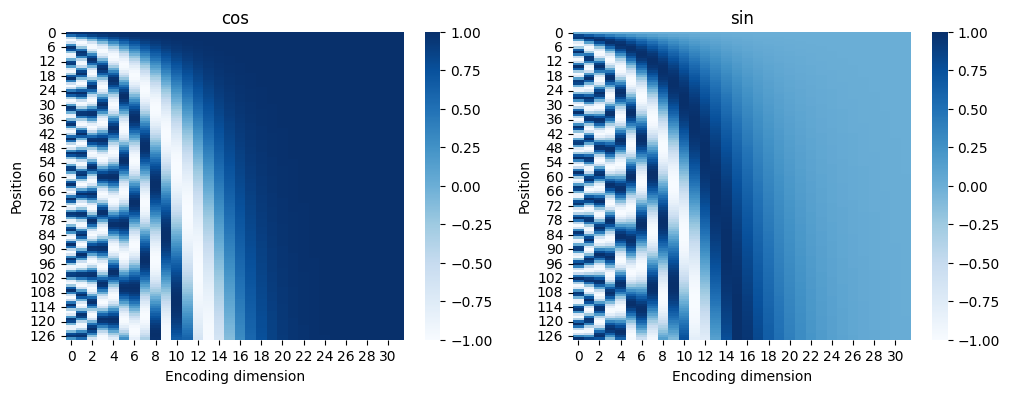

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

args ={"vmin":-1, "vmax":1, "cmap":'Blues'}
sns.heatmap(rope_cache[:, :, 0], ax=axes[0], **args)
axes[0].set_title("cos")
sns.heatmap(rope_cache[:, :, 1], ax=axes[1], **args)
axes[1].set_title("sin")

for ax in axes:
    ax.set_xlabel("Encoding dimension")
    ax.set_ylabel("Position")

### 相对位置

In [33]:
def compute_W_nm(i, j, dim=64):
    """
    Compute the W_nm matrix for positions i and j.
    """
    q = torch.randn(dim, 1)  # Random q for position i
    k = torch.randn(dim, 1)  # Random k for position j

    # Compute the Rotary embeddings for positions i and j
    rope_i = rope_model(1, offset=i)
    rope_j = rope_model(1, offset=j)

    # Adjust the apply_rotary_pos_emb function for single vectors
    def apply_single_rotary_emb(vec, rope):
        vec_dim = vec.shape[0]
        rope_dim = rope.shape[-2] * 2
        vec, vec_pass = vec[:rope_dim], vec[rope_dim:]
        vec_shaped = vec.reshape(rope_dim // 2, 2)
        rope_shaped = rope.view(-1, 2)
        out = torch.stack([
            vec_shaped[:, 0] * rope_shaped[:, 0] - vec_shaped[:, 1] * rope_shaped[:, 1],
            vec_shaped[:, 1] * rope_shaped[:, 0] + vec_shaped[:, 0] * rope_shaped[:, 1],
        ], dim=-1)
        out = out.flatten()
        return torch.cat((out, vec_pass))

    W_q_i = apply_single_rotary_emb(q.squeeze(), rope_i)
    W_k_j = apply_single_rotary_emb(k.squeeze(), rope_j)

    # Compute W_nm using outer product
    W_nm = torch.outer(W_q_i, W_k_j)

    return W_nm

# Compute W_10 for an example offset of 10
W_10 = compute_W_nm(0, 10)
W_10


tensor([[ 0.0224, -0.4032, -0.9586,  ..., -0.8224, -0.5325,  0.8584],
        [ 0.0099, -0.1787, -0.4249,  ..., -0.3645, -0.2360,  0.3805],
        [ 0.0262, -0.4715, -1.1212,  ..., -0.9618, -0.6228,  1.0040],
        ...,
        [ 0.0198, -0.3563, -0.8472,  ..., -0.7268, -0.4706,  0.7587],
        [ 0.0050, -0.0895, -0.2129,  ..., -0.1826, -0.1182,  0.1906],
        [ 0.0210, -0.3784, -0.8997,  ..., -0.7718, -0.4998,  0.8056]])

<Axes: >

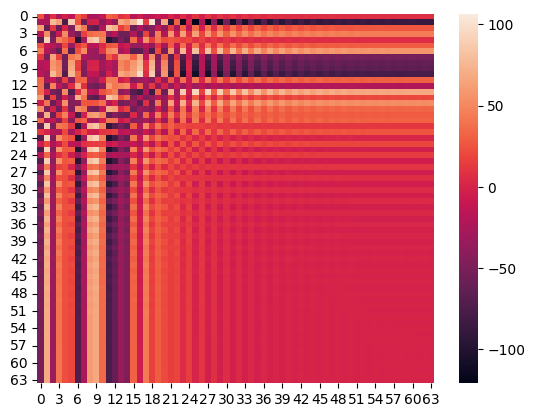

In [30]:
X.shape # [128, 1, 32, 64], seq_len, bs, num_heads, hidden_size


seq_len = 128
b = 1
np = 32
hn = 64
x = torch.ones(seq_len, b, np, hn)
rope_model = RotaryEmbedding(dim=64)
rope_cache = rope_model(seq_len)
X = apply_rotary_pos_emb(x, rope_cache)

i = 10
dt = 10
offset = 10

a = torch.mm(X[i][0].T, X[i + dt][0])
b = torch.mm(X[i + offset][0].T, X[i + offset + dt][0])

W_nm = a - b

# X[i].shape, X[i + diff].shape


Text(0.5, 1.0, 'sin')

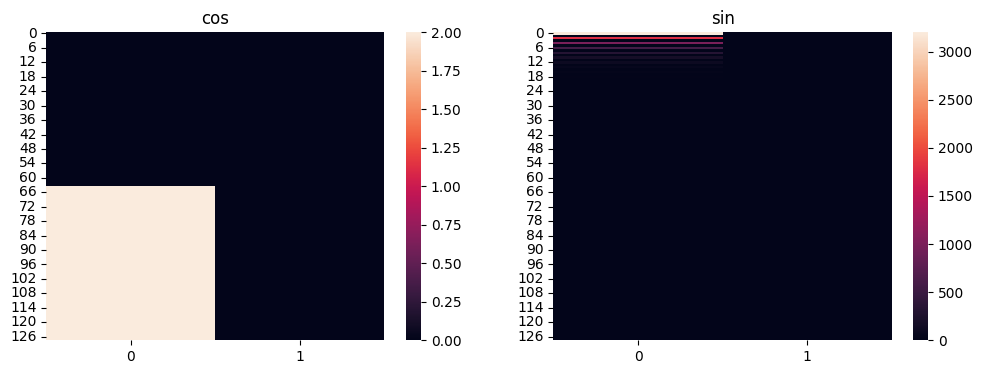

In [23]:
def get_relative_pos(X, n, m):
    cos_n, sin_n = X[n, :, 0], X[n, :, 1]
    cos_m, sin_m = X[m, :, 0], X[m, :, 1]
    cos_transformation = cos_m * cos_n + sin_m * sin_n
    sin_transformation = sin_m * cos_n - cos_m * sin_n

    W_relative = torch.stack([cos_transformation, sin_transformation], dim=-1)

    return W_relative.detach().numpy()


x0 = get_relative_pos(X, 0, 30)
x1 = get_relative_pos(X, 10, 40)

x0.shape

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

args = {}
sns.heatmap(x0[0], ax=axes[0], **args)
axes[0].set_title("cos")
sns.heatmap(x1[0], ax=axes[1], **args)
axes[1].set_title("sin")


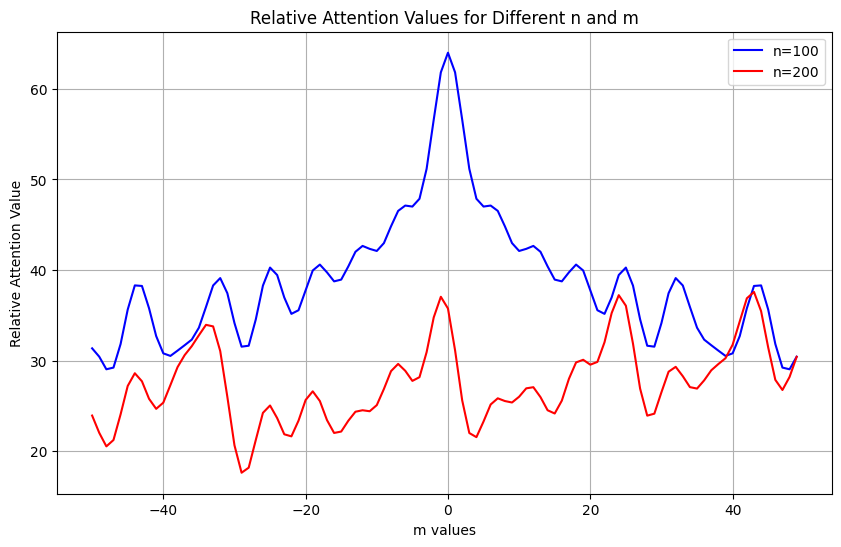

In [25]:
import torch
import matplotlib.pyplot as plt


# Function to compute W matrix
def compute_block_diagonal_W(n, theta):
    d = len(theta) * 2
    W = torch.zeros(d, d)
    for i in range(0, d, 2):
        W[i][i] = torch.cos(n * theta[i // 2])
        W[i][i + 1] = -torch.sin(n * theta[i // 2])
        W[i + 1][i] = torch.sin(n * theta[i // 2])
        W[i + 1][i + 1] = torch.cos(n * theta[i // 2])
    return W

# Function to compute relative attention values
def compute_relative_attention_for_positions_fixed(n, m_values, rope_model):
    dim = rope_model.dim
    q = torch.ones(dim, 1)
    k = torch.ones(dim, 1)
    theta = 1.0 / (10000 ** (torch.arange(0, dim, 2) / dim))
    attention_values = []
    for m in m_values:
        W_n = compute_block_diagonal_W(n, theta)
        W_m = compute_block_diagonal_W(m, theta)
        q_rot = torch.mm(W_m, q)
        k_rot = torch.mm(W_n, k)
        att_value = torch.mm(q_rot.T, k_rot)
        attention_values.append(att_value.item())
    return attention_values

# Define the parameters
n1 = 100
n2 = 200
m_values = np.array(range(-50, 50))

# Instantiate the RoPE model
rope_model = RotaryEmbedding(dim=64)

# Compute relative attention values
relative_attention_n1_fixed = compute_relative_attention_for_positions_fixed(n1, m_values + n1, rope_model)
relative_attention_n2_fixed = compute_relative_attention_for_positions_fixed(n2, m_values + n1, rope_model)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(m_values, relative_attention_n1_fixed, label=f"n={n1}", color='blue')
plt.plot(m_values, relative_attention_n2_fixed, label=f"n={n2}", color='red')
plt.xlabel("m values")
plt.ylabel("Relative Attention Value")
plt.title("Relative Attention Values for Different n and m")
plt.legend()
plt.grid(True)
plt.show()


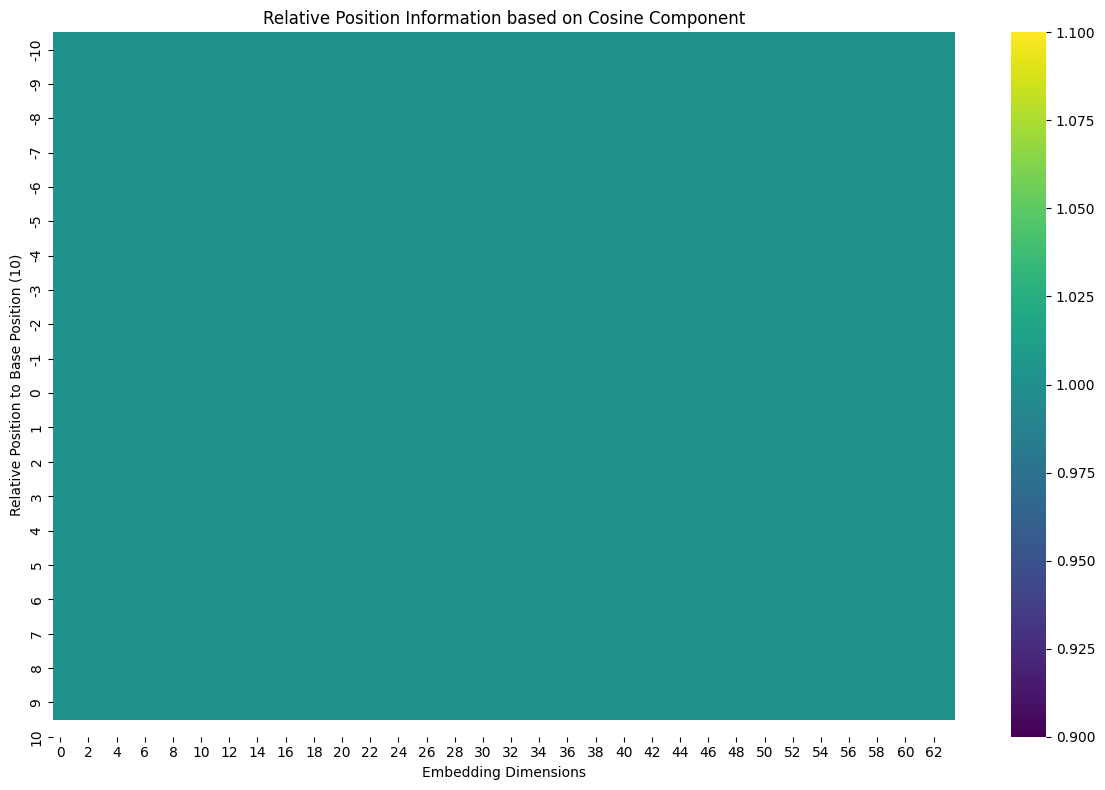

In [6]:

rotary_emb = RotaryEmbedding(dim=128)

def compute_transformation_matrix(W_m, W_n):
    # Ensure embeddings have the same sequence length
    min_len = min(W_m.size(0), W_n.size(0))
    
    # If either of the embeddings is empty, return None
    if min_len == 0:
        return None
    
    W_m, W_n = W_m[:min_len], W_n[:min_len]
    
    cos_m, sin_m = W_m[..., 0], W_m[..., 1]
    cos_n, sin_n = W_n[..., 0], W_n[..., 1]
    cos_transformation = cos_m * cos_n + sin_m * sin_n
    sin_transformation = sin_m * cos_n - cos_m * sin_n
    return torch.stack([cos_transformation, sin_transformation], dim=-1)

relative_positions = range(-10, 11)
transformation_matrices = []

base_position = 10  # Using 10 as the base position for comparison

for relative_position in relative_positions:
    target_position = base_position + relative_position
    W_base = rotary_emb.forward(base_position)
    W_target = rotary_emb.forward(target_position)
    transformation_matrix = compute_transformation_matrix(W_base, W_target)
    if transformation_matrix is not None:
        transformation_matrices.append(transformation_matrix[0, :, 0].numpy())  # Extracting the cosine component for visualization

plt.figure(figsize=(12, 8))
sns.heatmap(transformation_matrices, cmap='viridis', yticklabels=relative_positions)
plt.title('Relative Position Information based on Cosine Component')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Relative Position to Base Position (10)')
plt.tight_layout()
plt.show()


In [17]:
m, n = 10, 20
seq_len = 128
import numpy as np

def compute_rope(seq_len, m, n):
    rotary_emb = RotaryEmbedding(dim=seq_len)
    W = rotary_emb.forward(seq_len)

    cos_m, sin_m = W[m, :, 0], W[m, :, 1]
    cos_n, sin_n = W[n, :, 0], W[n, :, 1]
    cos_transformation = cos_m * cos_n + sin_m * sin_n
    sin_transformation = sin_m * cos_n - cos_m * sin_n

    W_relative = torch.stack([cos_transformation, sin_transformation], dim=-1)

    return W_relative.numpy()

W_relative = compute_rope(seq_len=128, m=10, n=20)
# sns.heatmap(W_relative)

W_relative_0 = compute_rope(seq_len=128, m=30, n=40)

np.allclose(W_relative, W_relative_0, 1e-4), W_relative_0.shape

(True, (64, 2))

In [18]:
seq_len = 128
rotary_emb = RotaryEmbedding(dim=seq_len)
X = rotary_emb.forward(seq_len)

np.allclose(X[10] * X[20], X[20] * X[30], 1e-0)


False

torch.Size([128, 64, 2])


<Axes: >

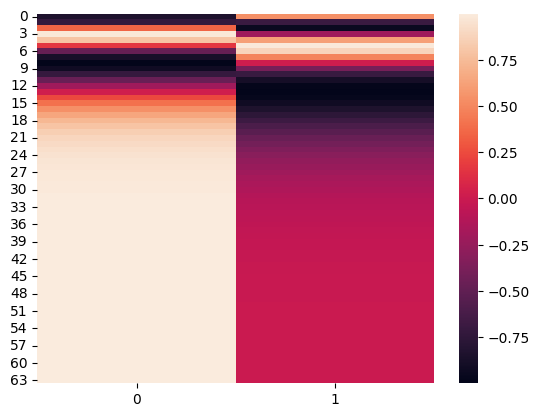

In [19]:
m, n = 20, 30
rotary_emb = RotaryEmbedding(dim=128)(128)
print(rotary_emb.shape)

cos_m, sin_m = rotary_emb[m, :, 0], rotary_emb[m, :, 1]
cos_n, sin_n = rotary_emb[n, :, 0], rotary_emb[n, :, 1]
cos_transformation = cos_m * cos_n + sin_m * sin_n
sin_transformation = sin_m * cos_n - cos_m * sin_n

pos = torch.stack([cos_transformation, sin_transformation], dim=-1)
sns.heatmap(pos)

### 长期衰减特性


Thank you for providing more details. Let's break down the provided information step by step:

1. RoPE is conceptually similar to Sinusoidal positional encoding. While Sinusoidal encoding is additive, RoPE is multiplicative.
2. For the choice of $ \theta_i $, the Sinusoidal positional encoding scheme is used, specifically $ \theta_i = 10000^{-2i/d} $. This ensures a long-term decay.
3. The equations provided demonstrate how the inner product after applying RoPE can be represented and decomposed.
4. The essence is to observe the term $ \frac{1}{d/2} \sum_{i=1}^{d/2} |S_i| $ as a representation of decay over relative distance.
5. The visualization in the reference image likely represents the decay of this term over relative distance.

Given this, our goal is to visualize how the term $ \frac{1}{d/2} \sum_{i=1}^{d/2} |S_i| $ decays with increasing relative distance (i.e., $ m - n $). 

Let's proceed with this calculation and visualization.

Here's the visualization of the "Long-term decay of RoPE" based on the provided information and the equations.

The plot showcases how the decay value, calculated as $\frac{1}{d/2} \sum_{i=1}^{d/2} |S_i|$, changes with increasing relative distance $ m - n $. As the relative distance increases, the decay value shows a decreasing trend, indicating the long-term decay property of RoPE.

Does this visualization align more closely with your expectations?

当然可以，这幅图描绘了RoPE（旋转位置嵌入）随相对距离的长期衰减特性。

1. **x轴 (相对距离)**: 表示两个序列位置之间的距离，即 \( m - n \)。例如，如果一个位置在序列的开始，另一个位置在序列的末尾，则它们之间的相对距离会很大。

2. **y轴 (相对大小)**: 这是一个表示嵌入值大小的衡量指标。具体来说，这个值是通过计算RoPE在每个相对距离上的嵌入值然后对其进行归一化得到的。

3. **图的趋势**: 从图中可以看到，随着相对距离的增加，RoPE的嵌入值呈现出衰减的趋势。这表明，当两个位置在序列中距离很远时，它们的嵌入值会减小。这种衰减性质有助于模型更好地捕捉到序列中不同位置的信息。

4. **为什么这很重要**：这种长期衰减性质确保了模型可以区分长序列中的不同位置。在自然语言处理中，位置信息对于理解上下文和句子结构非常重要。RoPE的这一特性使得模型能够在处理长文本时更好地捕捉到这些信息。

5. **与传统位置嵌入的对比**: 传统的位置嵌入，如Sinusoidal位置编码，也为序列中的每个位置提供了独特的嵌入。但RoPE的乘性特性使其与模型中的其他嵌入值结合得更为紧密，这有助于模型更好地捕捉位置信息。

总的来说，这幅图为我们提供了一个直观的方式来理解RoPE如何随着序列中位置的变化而变化，以及为什么这种变化对于模型的性能至关重要。

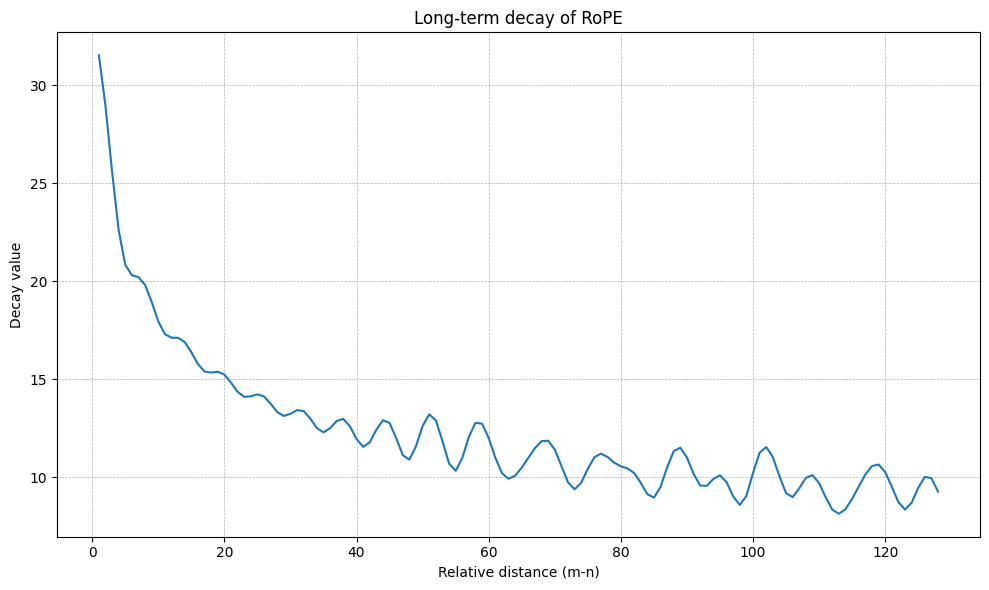

In [25]:
# Calculate the term representing decay over relative distance

# Configurations
d = 128  # Embedding dimension
relative_distances = torch.arange(1, seq_len + 1).float()  # Relative distances from 1 to seq_len

# Calculate theta values based on the given formula: θi = 10000^{-2i/d}
theta_values = 1.0 / (10000 ** (torch.arange(0, d, 2).float() / d))

# Calculate Si for each relative distance
Si_values = torch.cumsum(torch.exp(1j * torch.outer(relative_distances, theta_values)), dim=1)

# Calculate the term representing decay: (1/d/2) * sum(|Si|)
decay_values = torch.abs(Si_values).sum(dim=1) / (d / 2)

# Plot the decay over relative distance
plt.figure(figsize=(10, 6))
plt.plot(relative_distances, decay_values)
plt.title('Long-term decay of RoPE')
plt.xlabel('Relative distance (m-n)')
plt.ylabel('Decay value')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [26]:
a = torch.outer(relative_distances, theta_values)
b = torch.exp(1j * a)
c = torch.cumsum(b, dim=1)

print(a.shape, b.shape, c.shape)

torch.Size([128, 64]) torch.Size([128, 64]) torch.Size([128, 64])


/tmp/ipykernel_101201/172334381.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  sns.heatmap(c.numpy().astype(float))


<Axes: >

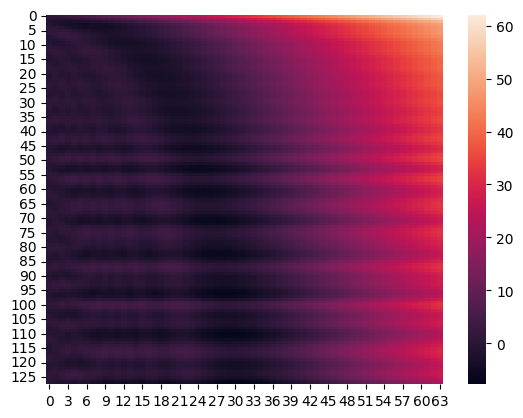

In [27]:
import seaborn as sns
sns.heatmap(c.numpy().astype(float))

<Axes: >

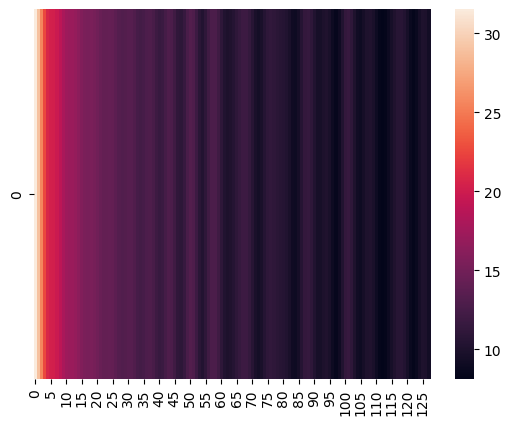

In [28]:
decay_values = torch.abs(Si_values).sum(dim=1).view(1, -1) / (d / 2)
sns.heatmap(decay_values.numpy().astype(float))